## Machine Learning : Theory and Applications (2025/26)
Simona Cocco & Vito Dichio

[✉ simona.cocco@phys.ens.fr](mailto:simona.cocco@phys.ens.fr) \\
[✉ vito.dichio@phys.ens.fr](mailto:vito.dichio@phys.ens.fr)


#### Bibliography:
[1] Cocco et al., *From Statistical Physics to Data-Driven Modelling: with Applications to Quantitative Biology*, Oxford University Press (2022)

[2] Peyrache et al., *Replay of rule-learning related neural patterns in the prefrontal cortex during sleep*. Nature neuroscience, 12(7), 919-926 (2009)

[3] Peyrache, A et al., Principal component analysis of ensemble recordings reveals cell assemblies at high temporal resolution. Journal of computational neuroscience, 29(1), 309-325 (2010).

[4] Diekelmann & Born. *The memory function of sleep. Nature reviews neuroscience*, 11(2), 114-126 (2010).

### Notes

# ML for Neuroscience — Tutorial 3 (START)

**Topic:** Principal Component Analysis (PCA) and replay of neural activity during sleep

**Goals**
- Apply PCA to multi-neuron spike recordings from task and sleep epochs
- Quantify correlations between neural activities and identify co-activated assemblies
- Use random matrix theory (Marčenko–Pastur distribution) to distinguish signal from noise
- Detect replay of task-related neural patterns during post-task sleep


**Note** / The present notebook is based on the *Tutorial 3: replay of neural activity during sleep following task learning* in [1], Section 3.3.

## Context and experimental data

In this tutorial, we study the **replay of neural activity during sleep following task learning**. This process is central to the two-stage model of memory consolidation - also known as active systems consolidation - in which hippocampal activity patterns are replayed during sleep to train and stabilize cortical memory traces, see for instance [4] - explore the mouse's brain regions though [this interactive 3D brain map](https://connectivity.brain-map.org/3d-viewer?v=1).

The dataset comes from [electrophysiological (multi-electrode) recordings](https://www.youtube.com/watch?v=LJkr-bJ1-dw) in the **prefrontal cortex** (PFC) of a rat performing a behavioral task (maze exploration), followed by sleep periods [2].
We aim to determine whether the collective neural patterns observed during the task are **reactivated** during post-task sleep, reflecting consolidation or replay of learned activity.

Neural activity was recorded continuously across three sessions:
1. **Sleep 1 (pre-task sleep)** - baseline neural activity before the task.
2. **Maze (task)** - neural activity while the animal performs the maze task.
3. **Sleep 2 (post-task sleep)** - neural activity after task completion.

Following [2,3], we will analyze neural population activity across the three sessions - pre-task sleep, task, and post-task sleep - to identify collective modes of correlated activity and detect possible replay of task-related patterns during sleep.

To this end, we will apply **Principal Component Analysis (PCA)** to extract dominant activity components and compare their structure across sessions. PCA provides a low-dimensional representation of the neural dynamics, allowing us to quantify correlations, detect assemblies of co-active neurons, and assess the reactivation of task-specific patterns during post-task sleep.

We start by loading the neural activity data. The three files correspond to the three recording sessions: **pre-task sleep**, **task**, and **post-task sleep**.
Each file contains a two-column array $\{t_i, i\}$, where $t_i$ is the spike time (in units of $0.1\ \mathrm{ms}$) and $i$ is the neuron index.

The following cell **imports**, **shifts**, and **rescales** the data so that, in the resulting variables $X_{\text{pre}}$, $X_{\text{task}}$, and $X_{\text{post}}$, the spike times are expressed in seconds, starting from $t = 0$.


In [1]:
import os
os.getcwd()

'C:\\Users\\Bruna\\Documents\\Cogmaster\\M2\\Machine Learning\\TD\\tutorial_3'

In [2]:
import os
import numpy as np

# --- Check that the data folder exists ---
if not os.path.isdir("data"):
    raise FileNotFoundError(
        "❌ The 'data' folder was not found. Please make sure you are in the correct working directory."
    )

# --- Load neural population activity ---
# Format: two columns
#   1st column → spike time (1 unit corresponds to 0.1 ms)
#   2nd column → neuron index (integer label)

X_pre  = np.loadtxt("data/Dati_181014_sleep1.txt")
X_task = np.loadtxt("data/Dati_181014_maze.txt")
X_post = np.loadtxt("data/Dati_181014_sleep2.txt")

# --- Sanity check ---
print("✅ Data successfully loaded. Shapes:")
print(f"  Pre-task sleep : {X_pre.shape}   (rows = spikes)")
print(f"  Task (maze)    : {X_task.shape}")
print(f"  Post-task sleep: {X_post.shape}")

# The original spike times are in units of 0.1 ms and do not start at 0. We convert them to seconds and shift them to start at 0.

def refine_spike_times(data):
    """Convert spike times from 0.1 ms to seconds and shift to start at 0."""
    data = data.copy()
    # Ensure float type for time manipulation
    data = data.astype(float)
    # Shift and scale
    data[:, 0] = (data[:, 0] - data[:, 0].min()) * 1e-4  # 0.1 ms = 1e-4 s
    return data

X_pre  = refine_spike_times(X_pre)
X_task = refine_spike_times(X_task)
X_post = refine_spike_times(X_post)

# --- Sanity check ---
print("\n ✅ Spike times converted to seconds and shifted to start at 0")
print(f"  Pre-task sleep : {X_pre[:,0].min():.1f} - {X_pre[:,0].max():.1f} s")
print(f"  Task (maze)     : {X_task[:,0].min():.1f} - {X_task[:,0].max():.1f} s")
print(f"  Post-task sleep: {X_post[:,0].min():.1f} - {X_post[:,0].max():.1f} s")


✅ Data successfully loaded. Shapes:
  Pre-task sleep : (317843, 2)   (rows = spikes)
  Task (maze)    : (304080, 2)
  Post-task sleep: (298054, 2)

 ✅ Spike times converted to seconds and shifted to start at 0
  Pre-task sleep : 0.0 - 1769.7 s
  Task (maze)     : 0.0 - 1408.5 s
  Post-task sleep: 0.0 - 1642.8 s


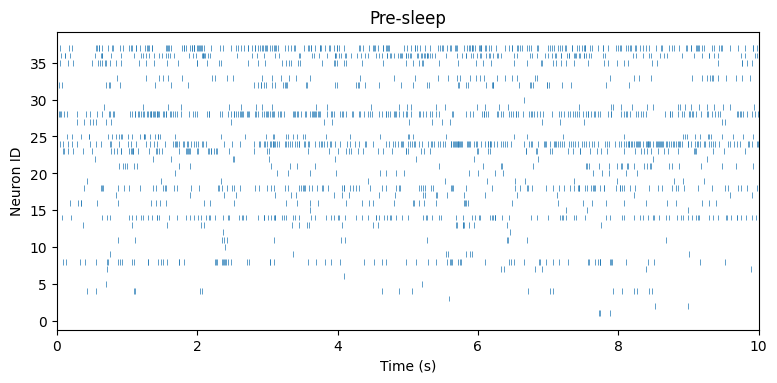

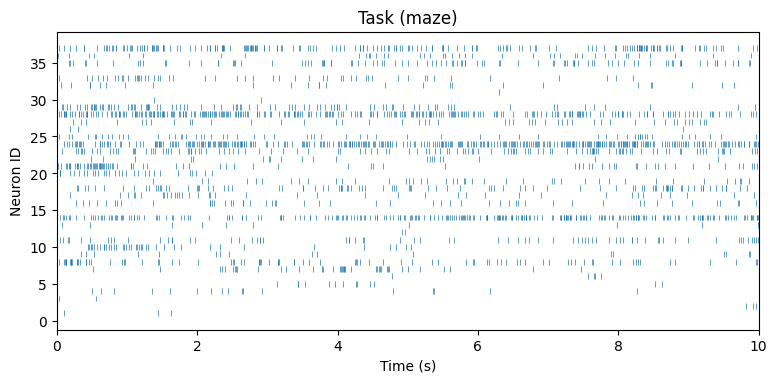

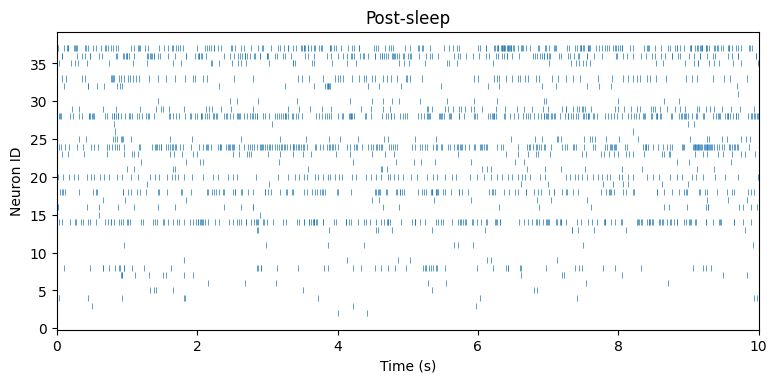

In [3]:
import matplotlib.pyplot as plt

def plot_spike_raster(session_data, t_range=(0,10), title=None):
    """
    Plot spike raster for a single session using vertical lines (vlines).

    Parameters
    ----------
    session_data : np.ndarray
        Array of shape (n_spikes, 2) with columns [time (s), neuron_id].
    t_range : tuple of float, optional
        (min_time, max_time) in seconds to display. Default is (0, 10).
    title : str or None, optional
        Plot title (e.g. 'Task (maze)'). If None, no title is displayed.
    """

    t_min, t_max = t_range

    # Select spikes within the specified time window
    mask = (session_data[:, 0] >= t_min) & (session_data[:, 0] <= t_max)
    times = session_data[mask, 0]
    neurons = session_data[mask, 1]

    ### Plot raster

    cm = 1/2.54 # useful to convert cm to inches to specify figure size in cm (1 inch = 2.54 cm). Cursed be the Imperial system of units
    plt.figure(figsize=(20*cm, 10*cm))

    plt.vlines(times, neurons - 0.4, neurons + 0.4,  linewidth=0.5)
    plt.xlim(t_min, t_max)
    plt.xlabel("Time (s)")
    plt.ylabel("Neuron ID")
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

t_range = (10,20) # Time window to display (in seconds)

# Plot spike rasters for the three sessions
plot_spike_raster(X_pre, t_range=(0,10), title="Pre-sleep")
plot_spike_raster(X_task, t_range=(0,10), title="Task (maze)")
plot_spike_raster(X_post, t_range=(0,10), title="Post-sleep")

In [12]:
X_pre[:,0].shape

(317843,)

In [6]:
X_pre[0].shape

(2,)

## 1 - From spikes to structured neural activity for PCA

 #### 🎯 Question 1a. Binning and spike-count matrices.
Using bins of width $\Delta = 0.1\,\mathrm{s}$ (100 ms), build the spike-count matrices
$$
S_{\text{pre}},\; S_{\text{task}},\; S_{\text{post}} \in \mathbb{R}^{M \times L},
$$
where each row corresponds to a time bin and each column to a neuron. Entry $S_{b,i}$ is the **number of spikes** of neuron $i$ in bin $b$.

Report the dimensions $M_{\text{pre}}, M_{\text{task}}, M_{\text{post}}$ and $L$.

##### 💡Hint for Question 1a
For a vectorized (efficient) implementation, consider using `np.ufunc.at`, see [the documentation](https://numpy.org/devdocs//reference/generated/numpy.ufunc.at.html).

In [125]:
round(np.max(X_pre[:,0]))

1770

In [127]:
X_pre

array([[1.0000000e+00, 1.0000000e+00],
       [7.7414000e+00, 1.0000000e+00],
       [7.8764000e+00, 1.0000000e+00],
       ...,
       [1.7696429e+03, 3.7000000e+01],
       [1.7696841e+03, 3.7000000e+01],
       [1.7697135e+03, 3.7000000e+01]])

In [4]:
# Create function to binarize spike-time matrix 
def bin_spike_trains(dt, X):
    """ Inputs:
            * X : shape (n_spikes, 2)
            X_{i,0} : i-th spike time (in seconds)
            X_{i,1} : neuron index corresponding to the i-th spike time

        Outputs:
            * S : shape (M,L)
            M : number of time bins
            L : number of neurons
    """
    # Compute total time
    T_total = round(np.max(X[:,0]))
    
    # Compute number of bins
    N_bins = int(T_total/dt)
    N_neurons = max(X[:,1]).astype(int) # the maximum index of the column #1 is the nb of neurons  
    
    # Initialize the spike-count matrices 
    S = np.zeros((N_bins, N_neurons), dtype=int)

    # Compute bin indices
    bin_idx = (X[:,0]/dt).astype(int)
    # Get neuron indices corresponding to the bin indices
    neuron_idx = (X[:,1]).astype(int) - 1
    
    np.add.at(S, (bin_idx, neuron_idx), 1) #not sure

    return S
        
# Define time bin width (delta)
delta = 0.1 # in seconds

S_pre = bin_spike_trains(delta, X_pre)
S_task = bin_spike_trains(delta, X_task)
S_post = bin_spike_trains(delta, X_post)

In [4]:
S_pre.shape

(17700, 37)

In [7]:
# OBS : assert in python

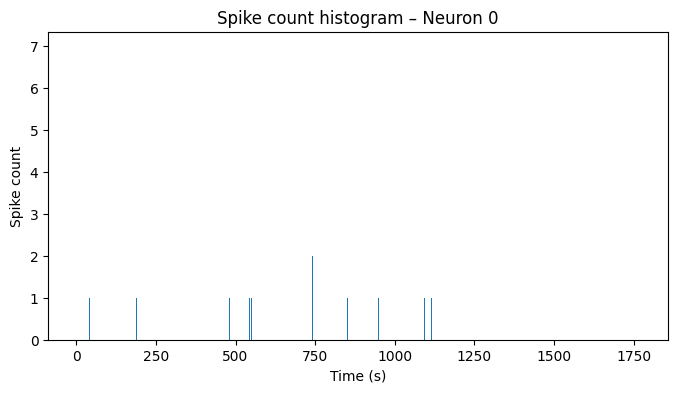

In [5]:
# Choose a neuron to inspect
i = 0

# Compute total time
T_total = round(np.max(X_pre[:,0]))
N_bins = int(T_total/delta)

# Time axis for bins
bin_edges = np.arange(0, N_bins * delta + delta, delta)
bin_centers = bin_edges[:-1] + delta / 2

plt.figure(figsize=(8, 4))
plt.bar(bin_centers, S_pre[:, i], width=delta, align='center')
plt.xlabel("Time (s)")
plt.ylabel("Spike count")
plt.title(f"Spike count histogram – Neuron {i}")
plt.show()

 #### 🎯 Question 1b. Z-scoring per neuron.
For each session, compute the z-scored matrix $Y$ from $S$ by normalizing **each neuron (column)**:

$$
p_i = \frac{1}{M}\sum_{b=1}^M S_{b,i},
\qquad
\sigma_i^2 = \frac{1}{M-1}\sum_{b=1}^M (S_{b,i}-p_i)^2,
\qquad
Y_{b,i} = \frac{S_{b,i}-p_i}{\sigma_i}.
$$


In [8]:
# Test only with S_pre first
M_t = len(S_pre)
print(M_t)
p_t = np.sum(S_pre, axis = 0)/M_t
print(p_t)
var_t = 1/(M_t-1)*np.sum((S_pre - p_t)**2, axis = 0)
print(var_t)
Y_t = (S_pre - p_t)/np.sqrt(var_t)
print(Y_t)

17700
[0.01920904 0.03774011 0.05       0.20322034 0.05836158 0.06627119
 0.16096045 0.60480226 0.03259887 0.01898305 0.29169492 0.03954802
 0.17028249 1.5859322  0.02903955 0.31700565 0.28135593 0.93384181
 0.18101695 0.38418079 0.36559322 0.11745763 0.94220339 2.00661017
 0.53378531 0.01553672 0.17892655 2.47016949 0.39079096 0.0539548
 0.02734463 0.31090395 0.61700565 0.01813559 0.72322034 1.38564972
 2.33389831]
[0.02901118 0.06298602 0.06840782 0.2577556  0.08840683 0.09951206
 0.25178957 0.79668862 0.05402511 0.03139283 0.40425895 0.06329829
 0.20807778 1.81932861 0.03373488 0.31280193 0.32164797 0.98748679
 0.18340142 0.42983053 0.48925059 0.12219931 1.2029987  2.79723299
 0.57589674 0.04252937 0.19539746 2.36653198 0.40080789 0.06325064
 0.03462146 0.47234847 0.86087809 0.03181979 0.78191177 1.30999237
 2.25101198]
[[-0.11277762 -0.15037689 -0.19116885 ...  0.3130079  -0.3369447
  -0.88906562]
 [-0.11277762 -0.15037689 -0.19116885 ...  0.3130079   1.4104685
  -0.88906562]
 [-0.

In [9]:
def compute_z_score(S):
    " Computes z-scored matrix Y given a binarized spike-count matrix S "
    M = len(S)
    p = np.sum(S, axis = 0)/M
    var = 1/(M-1)*np.sum((S - p)**2, axis = 0)
    Y = (S - p)/np.sqrt(var)
    return Y

Y_pre = compute_z_score(S_pre)
Y_task = compute_z_score(S_task)
Y_post = compute_z_score(S_post)

In [21]:
print(Y_pre.shape)

(17700, 37)


In [112]:
# Weird that the value is always the same ???

In [10]:
Y_task

array([[-0.29096318, -0.13546185,  5.10373975, ..., -0.97632794,
         1.0570105 , -0.60252586],
       [ 1.63286186, -0.13546185, -0.14835586, ...,  0.68839774,
         1.0570105 ,  0.10440972],
       [-0.29096318, -0.13546185, -0.14835586, ..., -0.1439651 ,
        -0.57530843, -0.60252586],
       ...,
       [-0.29096318, -0.13546185, -0.14835586, ..., -0.97632794,
        -0.57530843, -1.30946143],
       [-0.29096318, -0.13546185, -0.14835586, ..., -0.97632794,
        -0.57530843, -1.30946143],
       [-0.29096318, -0.13546185, -0.14835586, ..., -0.97632794,
        -0.57530843, -1.30946143]])

#### 🎯 Question 1c. Correlation, spectrum, and Marčenko–Pastur test (task session)

For the **task** session, build the sample correlation matrix from the z-scored data
$$
C_{\text{task}} \;=\; \frac{1}{M_{\text{task}}}\, Y_{\text{task}}^{\top} Y_{\text{task}} \;\in\; \mathbb{R}^{L\times L},
$$
where each column of $Y_{\text{task}}$ has zero mean and unit variance.

Compute the eigenvalue spectrum and the eigenvectors of $C_{\text{task}}$ and print the first 10 eigenvalues.

##### 💡 Hint for Question 1c
You can use `np.linalg.eigh` to compute the eigenvalues and eigenvectors of a symmetric matrix. This function is optimized for Hermitian (symmetric) matrices and is more efficient than the general-purpose `np.linalg.eig` function. Alternatively, you can use `scipy.linalg.eigh`, which provides similar functionality with additional options.

In [17]:
Y_pre.T.shape

(37, 17700)

In [10]:
def compute_corr_matrix(Y):
    """" Computes correlation matrix out of z-scored data Y
    """
    M = len(Y)
    C = (1/M)*(Y.T @ Y)
    return C

C_task = compute_corr_matrix(Y_task)
C_task_eigenvals, C_task_eigenvecs = np.linalg.eigh(C_task)


print(C_task)

print("First 10 eigenvalues of C_{task}:")
print(C_task_eigenvals[-10:][::-1])  # largest 10 eigenvals in descending order

[[ 0.99992903 -0.02308578 -0.02093561 ... -0.00733912  0.01580894
   0.11532033]
 [-0.02308578  0.99992903  0.01913173 ... -0.00876336 -0.01364772
  -0.00649707]
 [-0.02093561  0.01913173  0.99992903 ...  0.00842748  0.01261047
  -0.01059796]
 ...
 [-0.00733912 -0.00876336  0.00842748 ...  0.99992903 -0.02467778
  -0.03884165]
 [ 0.01580894 -0.01364772  0.01261047 ... -0.02467778  0.99992903
   0.01780837]
 [ 0.11532033 -0.00649707 -0.01059796 ... -0.03884165  0.01780837
   0.99992903]]
First 10 eigenvalues of C_{task}:
[2.15102607 1.46382949 1.33676469 1.30714784 1.16343143 1.12434099
 1.10357184 1.07534192 1.06450432 1.05425356]


In [18]:
# TODO : check : why not EXACTLY the same

In [19]:
C_task.shape

(37, 37)

In [20]:
C_task_eigenvals

array([0.5309163 , 0.69692799, 0.74211297, 0.7689645 , 0.7905287 ,
       0.81308128, 0.83294206, 0.85226889, 0.85937534, 0.87017754,
       0.87951026, 0.89674311, 0.90662877, 0.91570735, 0.92874384,
       0.93159214, 0.95032823, 0.95720717, 0.96740896, 0.97315348,
       0.97791226, 0.99673872, 1.00186828, 1.01352275, 1.02181517,
       1.02980578, 1.04718005, 1.05425356, 1.06450432, 1.07534192,
       1.10357184, 1.12434099, 1.16343143, 1.30714784, 1.33676469,
       1.46382949, 2.15102607])

## 2. Marčenko–Pastur test for significant components

When applying PCA to neural population activity, some principal components reflect true correlated structure, while others arise purely from finite-sample noise. The **Marčenko–Pastur (MP) distribution** provides the theoretical eigenvalue spectrum of a correlation matrix built from *uncorrelated* (random) data.
By comparing the empirical spectrum of $C_{\text{task}}$ to this reference, we can detect **significant components** - those that exceed the range expected from noise.

The MP distribution depends on the **aspect ratio**
$$
r = \frac{L}{M_{\text{task}}},
$$
where $L$ is the number of neurons (variables) and $M_{\text{task}}$ is the number of time bins (samples).

The ratio $r$ determines the width of the random “noise bulk”: **small $r$** (many samples) imply a narrow spectrum while **large $r$** (few samples) → broad spectrum.

The MP distribution has support on $[\lambda_-, \lambda_+]$, with
$$
\lambda_{\pm} = (1 \pm \sqrt{r})^2,
$$
and density
$$
\rho_{\text{MP}}(\lambda)
= \frac{\sqrt{(\lambda_+ - \lambda)(\lambda - \lambda_-)}}{2\pi\, r\, \lambda},
\qquad \lambda \in [\lambda_-, \lambda_+].
$$

Eigenvalues **outside** this interval indicate collective modes not explained by random correlations - i.e., potential **signal components** in the neural population activity.

*(See Eq. (3.25) in [1].)*


#### 🎯 Question 2a. Significant components in the task session

Plot the **eigenvalue spectrum** of the task correlation matrix $C_{\text{task}}$.

(i) Plot the **histogram of empirical eigenvalues**. On the same figure, overlay the **Marčenko–Pastur (MP)** density, which gives the expected eigenvalue distribution for purely random (uncorrelated) data with the same aspect ratio $r = L / M_{\text{task}}$.

(ii) Determine how many empirical eigenvalues lie **above** the theoretical upper bound $\lambda_{+}$ - these correspond to **significant principal components**, i.e. correlated population modes that exceed random noise fluctuations.


In [8]:
C_task
# TODO: solve why not rly equal to 1 in the diag => numerical pb?

array([[ 0.99992903, -0.02308578, -0.02093561, ..., -0.00733912,
         0.01580894,  0.11532033],
       [-0.02308578,  0.99992903,  0.01913173, ..., -0.00876336,
        -0.01364772, -0.00649707],
       [-0.02093561,  0.01913173,  0.99992903, ...,  0.00842748,
         0.01261047, -0.01059796],
       ...,
       [-0.00733912, -0.00876336,  0.00842748, ...,  0.99992903,
        -0.02467778, -0.03884165],
       [ 0.01580894, -0.01364772,  0.01261047, ..., -0.02467778,
         0.99992903,  0.01780837],
       [ 0.11532033, -0.00649707, -0.01059796, ..., -0.03884165,
         0.01780837,  0.99992903]])

In [10]:
C_task.shape

(37, 37)

C:\Users\Bruna\AppData\Local\Temp\ipykernel_5024\902564997.py:25: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt((a_plus - a) * (a - a_minus)) / (2*np.pi*r*a),


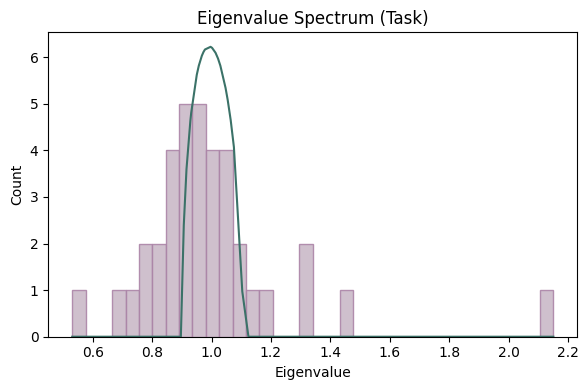

In [11]:
# (i)

def plot_hist(eigenvals, bins, title=None):
    """ Plot histogram of eigenvalues """
    plt.figure(figsize=(6,4))
    plt.hist(eigenvals, bins=bins, color = '#CABAC8', edgecolor='#AB84A7', alpha=0.9)
    plt.xlabel("Eigenvalue")
    plt.ylabel("Count")
    if title:
        plt.title(title)
    plt.tight_layout()
    #plt.show()

def marcenko_pastur(Y, a):
    """ Compute Marcenko-Pastur (MP) distribution """
    # Get number of time bins M and number of neurons L from z-scored data of one session Y
    M, L = Y.shape
    # Compute aspect ratio r
    r = L/M
    # Compute parameters of distribution
    a_plus = (1+np.sqrt(r))**2
    a_minus = (1-np.sqrt(r))**2
    # Compute density fo Marcenko-Pastur distribution
    dens = np.where((a >= a_minus) & (a <= a_plus),
                np.sqrt((a_plus - a) * (a - a_minus)) / (2*np.pi*r*a),
                0)
    return a_plus, dens

# Get theoretical upper bound and Marcenko-Pastur distribution
upper_bound, dens = marcenko_pastur(Y_task, C_task_eigenvals)
# Get number of bins
bins = len(C_task_eigenvals) - 1

plot_hist(C_task_eigenvals, bins, title="Eigenvalue Spectrum (Task)")
plt.plot(C_task_eigenvals, dens, color = "#3B7268")

In [12]:
# (ii) 
# Get significant eigenvalues of the task correlation matrix (in descending order)
Ct_sig_eigvals = C_task_eigenvals[C_task_eigenvals > upper_bound]
print(f"The significant principal components are: {Ct_sig_eigvals}")

The significant principal components are: [1.12434099 1.16343143 1.30714784 1.33676469 1.46382949 2.15102607]


#### 🎯 Question 2b. Shuffled control and validation of the MP

To test whether the empirical spectrum during the task deviates from random expectations, create a **shuffled control** dataset. In particular, consider again $Y_{\text{task}}$.

(i) For each neuron, randomly **permute** its activity values across the $M$ time bins so to preserve the firing rate distribution of individual neurons but destroy correlations between them.

(ii) Repeat (1.c) and (2.a) for this shuffled activity matrix. Plot the corresponding eigenvalue spectrum and verify that it is well described by the **Marčenko–Pastur distribution**.

##### 💡 Hint for Question 2b.i
Use `np.random.shuffle` to permute the activity values of each neuron (column) independently, see [the documentation](https://numpy.org/doc/2.2/reference/random/generated/numpy.random.shuffle.html).


(i)
Y shape: (14090, 37)
Y shuffled shape: (14090, 37)
First 10 eigenvalues of C_{task}:
[1.0846624  1.07875616 1.07282123 1.06909862 1.0593207  1.05356232
 1.04900816 1.04809755 1.0467696  1.03841222]

(ii)
The significant principal components are: []


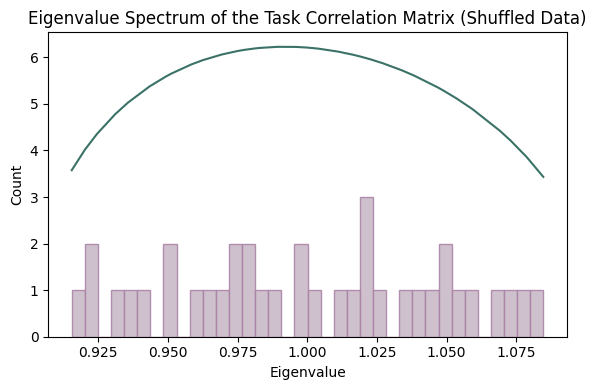

In [23]:
# (i)
def shuffle_data(Y):
    """ Create a shuffled control dataset out of a z-scored data matrix
    
    Inputs:
        * Y : z-scored data, shape (M, L) where M is nb of time bins and L nb of neurons
    
    Outputs:
        * Y_shuffle : same matrix as input but shuffled across the M time bins, shape (M, L)
    """
    # Make a copy of initial data matrix Y
    Y_shuffle = Y
    M, L = Y.shape
    # Use in-place shuffling function
    for i in range(L):
        np.random.shuffle(Y_shuffle[:, i])
    # Verify shape is the same as initial data matrix
    print(f"Y shape: {Y.shape}\nY shuffled shape: {Y_shuffle.shape}")
    return Y_shuffle

print("(i)")
Y_task_shuffle = shuffle_data(Y_task)

# (ii)
Ct_shuffle = compute_corr_matrix(Y_task_shuffle)
Ct_eigvals_shuffle, Ct_eigvecs_shuffle = np.linalg.eigh(Ct_shuffle)

print("First 10 eigenvalues of C_{task}:")
print(Ct_eigvals_shuffle[-10:][::-1])  # largest 10 eigenvals in descending order

# Get theoretical upper bound and Marcenko-Pastur distribution
upper_bound, dens = marcenko_pastur(Y_task_shuffle, Ct_eigvals_shuffle)
# Get number of bins
bins = len(Ct_eigvals_shuffle) - 1

plot_hist(Ct_eigvals_shuffle, bins, title="Eigenvalue Spectrum (Task)")
plt.plot(Ct_eigvals_shuffle, dens, color = "#3B7268")
plt.title("Eigenvalue Spectrum of the Task Correlation Matrix (Shuffled Data)")

# Get significant eigenvalues of the task correlation matrix (in descending order)
Ct_sig_eigvals_shuffle = Ct_eigvals_shuffle[Ct_eigvals_shuffle > upper_bound]
print("\n(ii)")
print(f"The significant principal components are: {Ct_sig_eigvals_shuffle}")


#### 🎯 Question 2c. Identifying task-related neural assemblies

Inspect the **largest principal component** of the task activity, i.e. the eigenvector associated with the largest eigenvalue of \$C_{\text{task}} $. Compute and visualize the absolute value of all neuron loadings (the components of the first eigenvector), which quantify each neuron's contribution to the dominant population mode. Then, compare each neuron's loading with the baseline level expected for random, unstructured activity:
$$
|v_i|_{\text{baseline}} = \frac{1}{\sqrt{L}},
$$
where $L$ is the total number of neurons. Neurons with $ |v_i| > |v_i|_{\text{baseline}} $ contribute significantly above chance and define a **cell assembly** - a subset of neurons that tend to coactivate during the task.


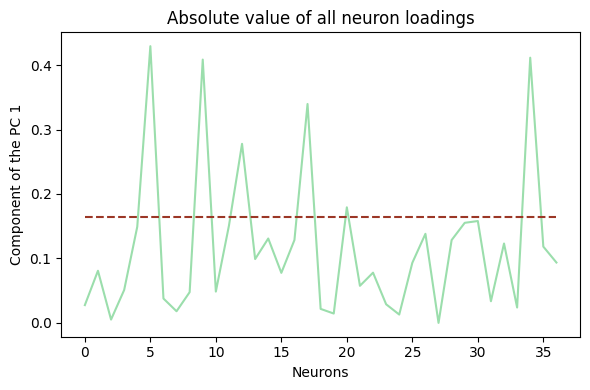

In [17]:
# Get the eigenvector associated with the largest eigenvalue of C_task
PC1_task = C_task_eigenvecs[-1]

# Compute absolute value of neuron loadings
abs_PC1_task = abs(PC1_task)

# Get number of neurons L
L = PC1_task.shape[0]
v_baseline = 1/np.sqrt(L)

# Plot absolute value of components of first eigenvector for each neuron
plt.figure(figsize=(6,4))
plt.plot(np.arange(0,L), abs_PC1_task, color = '#9BDEAC')
plt.hlines(v_baseline, xmin = 0, xmax = L-1, linestyle = "--", color = '#9B3726')
plt.xlabel("Neurons")
plt.ylabel("Component of the PC 1")
plt.title("Absolute value of all neuron loadings")
plt.tight_layout()
plt.show()



## 3. Replay analysis
#### Quantifying task reactivation during sleep
To test whether task-related neural patterns are **reactivated during sleep**, we define measures of **replay** that quantify the similarity between the neural correlation structure during the task and the activity observed during sleep.

Following Peyrache *et al.* [2,3], the instantaneous replay between the **task** correlation matrix and the activity during a **sleep** epoch (either pre- or post-task) is defined as

$$
R^{\text{match}}(b)
= \frac{1}{2} \sum_{i \ne j} Y_{bi}^{\text{match}}\, C_{ij}^{\text{task}}\, Y_{bj}^{\text{match}},
$$

where:
- $Y_{bi}^{\text{match}}$ is the z-scored activity of neuron $i$ in time bin $b$ of the selected sleep session, and
- $C_{ij}^{\text{task}}$ is the correlation matrix estimated during the task.

This quantity measures how much the instantaneous population pattern during sleep resembles the coactivation structure learned during the task.
Averaging over all time bins gives the **total replay**:

$$
R^{\text{match}} = \frac{1}{2M}\sum_b \sum_{i \ne j}
Y_{bi}^{\text{match}}\, C_{ij}^{\text{task}}\, Y_{bj}^{\text{match}} = \frac{1}{2}\sum_{i \ne j}
C_{ij}^{\text{match}}\ C_{ij}^{\text{template}} \sim \frac{1}{2}Tr[(C^{\text{match}}-\mathbb{1}_L)(C^{\text{template}}-\mathbb{1}_L)].
$$

A larger $R^{\text{match}}$ indicates stronger reactivation of task-related assemblies.

#### 🎯 Question 3a. Total replay during sleep

Compute the **total replay** $R^{\text{match}}$ for **task** (template) and both **pre-task** and **post-task** sleep epochs (match).
Compare their values: is replay stronger after the task?


In [106]:
Y_task.shape

(14090, 37)

In [18]:
# Compare task and pre-task sleep and task and post-task sleep

def compute_R(Y_temp, Y_match):
    """ Compute instantaneous replay between task correlation matrix and the activity during a sleep epoch from the z-scored activity of neuron Y

    Inputs:
        * Y_temp: template data, often the task data, shape (M, L) where M is the number of time bins and L the number of neurons
        * Y_match: activity during a sleep epoch, either pre- or post-task, shape (M, L)
        
    """
    C_temp = compute_corr_matrix(Y_temp)
    C_match = compute_corr_matrix(Y_match)
    # Compute identity of same size as C
    I_L = np.ones_like(C_temp)
    R = 1/2*np.trace((C_match - I_L)*(C_temp - I_L))

    return R

R_pre = compute_R(Y_task, Y_pre)
R_post = compute_R(Y_task, Y_post)

print(f"The total replay for the task and pre-task sleep epoch is {R_pre:.10f}.\nThe total replay for the task and post-task sleep epoch is {R_post:.10f}.")

The total replay for the task and pre-task sleep epoch is 0.0000000742.
The total replay for the task and post-task sleep epoch is 0.0000000799.


#### Decomposition into principal components

Using the eigenvalue decomposition of the task correlation matrix

$$
C_{ij}^{\text{task}} = \sum_k \lambda_k\, v_i^k v_j^k,
$$

the instantaneous replay can be rewritten as a sum of contributions from individual principal components:

$$
R^{\text{match}}(b)
= \sum_k \lambda_k\, R_k^{\text{match}}(b),
$$

with
$$
R_k^{\text{match}}(b)
= \frac{1}{2}
\left[
\left(\sum_i Y_{bi}^{\text{match}} \ v_i^k\right)^2
- \sum_i (Y_{bi}^{\text{match}} \ v_i^k)^2
\right].
$$

Each term $R_k^{\text{match}}(b)$ measures how much the activity in bin $b$ projects onto the $k$-th task component.


#### 🎯 Question 3b. Component-wise replay over time

Compute the **instantaneous replay** $ R_k^{\text{match}}(b) $ for each **significant** principal component of the **task** (template) as a function of time, using both **pre-task** and **post-task** sleep epochs as the matching datasets. The resulting replay matrix $R_k^{\text{match}}(b) $ should have dimensions `M × N_sig`, where `M` is the number of time bins and `N_sig` is the number of significant components identified in Question 2a.

Then, **visualize** the instantaneous replay associated with the **largest significant principal component** (i.e., $k = 1 $).
Discuss whether replay events - brief transient reactivations of the task-related activity pattern - appear **more frequent or stronger after the task** compared to before.



In [25]:
def instant_replay(Y_temp, Y_match):
    # Get correlation matrix of the template (often, the task matrix)
    C_temp = compute_corr_matrix(Y_temp)
    C_temp_eigenvals, C_temp_eigenvecs = np.linalg.eigh(C_temp)
    # Compute theoretical upper bound from Marcenko-Pastur distribution
    upper_bound, _ = marcenko_pastur(Y_temp, C_temp_eigenvals)
    # Keep only significant PCs 
    Ct_sig_eigvals = C_temp_eigenvals[C_temp_eigenvals > upper_bound]
    sig_nb = Ct_sig_eigvals.shape[0]
    Ct_sig_eigvecs = C_temp_eigenvecs[:,-sig_nb:] 
    # Obs: shape (Nb neurons x sig eigenvalues), which is correct bc columns are eigenvalues in eigenvector matrix
    M, L = Y_task.shape # number of time bins, number of neurons
    R_match = np.zeros((M, sig_nb))
    for b in range(M):
        for k in range(sig_nb):
            # Get the k-th significant eigenvector
            v = C_task_eigenvecs[:,k].reshape(L,1) # reshape to have shape (L,1) instead of (L,)
            # Compute product between Y and v
            product = Y_match[b,:] @ v
            # Compute element-wise multiplication 
            element_wise = Y_match[b,:] * v
            # Get element b, k of the R 
            R_match[b,k] = 1/2*(np.square(product) - np.sum(np.square(element_wise)))

    return R_match

R_post = instant_replay(Y_task, Y_post)

In [26]:
print(R_post)

[]


In [27]:
from tqdm import tqdm

# Get correlation matrix of the template (often, the task matrix)
Y_temp = Y_task
Y_match = Y_post

C_temp = compute_corr_matrix(Y_temp)
print(f"C_temp: {C_temp}")
C_temp_eigenvals, C_temp_eigenvecs = np.linalg.eigh(C_temp)
print(f"eigenvals, eigenvecs: {C_temp_eigenvals, C_temp_eigenvecs}")
# Compute theoretical upper bound from Marcenko-Pastur distribution
upper_bound, _ = marcenko_pastur(Y_temp, C_temp_eigenvals)
print(f"upper bound {upper_bound}")
# Keep only significant PCs 
Ct_sig_eigvals = C_temp_eigenvals[C_temp_eigenvals > upper_bound]
print("Ct_sig_eigvals:",Ct_sig_eigvals.shape)
sig_nb = Ct_sig_eigvals.shape[0]
print("Sig_nb", sig_nb)
Ct_sig_eigvecs = C_temp_eigenvecs[:,-sig_nb:] 
print("Ct_sig_eigvecs:",Ct_sig_eigvecs.shape)
# Obs: shape (Nb neurons x sig eigenvalues), which is correct bc columns are eigenvalues in eigenvector matrix
M, L = Y_task.shape # number of time bins, number of neurons
R_match = np.zeros((M, sig_nb))
print(R_match.shape)
for b in tqdm(range(M)):
    #print(b)
    for k in range(sig_nb):
        # Get the k-th significant eigenvector
        v = C_task_eigenvecs[:,k].reshape(L,1) # reshape to have shape (L,1) instead of (L,)
        #print(f"v:{v}")
        # Compute product between Y and v
        product = Y_match[b,:] @ v
        # Compute element-wise multiplication between Y and v
        element_wise = Y_match[b,:] * v
        #print(f"product:{product}")
        # Get element b, k of the R 
        R_match[b,k] = 1/2*(product - np.sum(np.square(element_wise)))
        #print(f"R_match: {R_match}")

R_match

C_temp: [[ 0.99992903 -0.00153199 -0.00444202 ...  0.0090264  -0.00959871
  -0.00263176]
 [-0.00153199  0.99992903  0.0030838  ...  0.00960499 -0.00145581
   0.00982341]
 [-0.00444202  0.0030838   0.99992903 ...  0.00160162 -0.01051072
   0.00152362]
 ...
 [ 0.0090264   0.00960499  0.00160162 ...  0.99992903 -0.00606702
  -0.00664313]
 [-0.00959871 -0.00145581 -0.01051072 ... -0.00606702  0.99992903
   0.00208393]
 [-0.00263176  0.00982341  0.00152362 ... -0.00664313  0.00208393
   0.99992903]]
eigenvals, eigenvecs: (array([0.91552426, 0.92026154, 0.92459555, 0.9311492 , 0.93571241,
       0.94345705, 0.94940869, 0.95138365, 0.95845788, 0.96259946,
       0.96942048, 0.97502791, 0.97642254, 0.97751688, 0.98119744,
       0.9827455 , 0.98924849, 0.99619475, 1.00008268, 1.00395279,
       1.01103971, 1.01648567, 1.01918188, 1.02199251, 1.02289727,
       1.02703825, 1.03387066, 1.03841222, 1.0467696 , 1.04809755,
       1.04900816, 1.05356232, 1.0593207 , 1.06909862, 1.07282123,
       1

100%|███████████████████████████████████████████████████████████████████████| 14090/14090 [00:00<00:00, 2767655.29it/s]


array([], shape=(14090, 0), dtype=float64)

In [24]:
def instantaneous_replay(Y_match, eigvals_template, eigvecs_template, k_sig=None):
    """
    Compute instantaneous replay R_k^match(b) for each principal component k
    over all time bins b in the match session.

    Parameters
    ----------
    Y_match : np.ndarray, shape (M_match, L)
        Z-scored spike-count matrix for the match session (pre- or post-task sleep).
    eigvals_template : np.ndarray, shape (L,)
        Eigenvalues of the template correlation matrix (task session).
        Must be sorted in ascending order (as returned by np.linalg.eigh).
    eigvecs_template : np.ndarray, shape (L, L)
        Corresponding eigenvectors (columns) from the same decomposition.
    k_sig : int or None, optional
        If set, compute only the first k_sig *largest* components.

    Returns
    -------
    R_k_match : np.ndarray, shape (M_match, k)
        Instantaneous replay contributions R_k^match(b) for each component k and time bin b.
    """
    M_match, L = Y_match.shape
    k = L if k_sig is None else int(k_sig)

    # eigvecs_template are in ascending order (from np.linalg.eigh)
    # Select top-k (largest) eigenvectors by reversing order
    top_eigenvecs = eigvecs_template[:, ::-1][:, :k]   # shape (L, k), now in descending order

    # Initialize replay matrix
    R_k_match = np.zeros((M_match, k))

    # Compute R_k^{match}(b) for each component
    for i in range(k):
        v_k = top_eigenvecs[:, i]
        proj = Y_match @ v_k                      # (M_match,)
        term1 = proj**2
        term2 = np.sum((Y_match * v_k)**2, axis=1)
        R_k_match[:, i] = 0.5 * (term1 - term2)

    return R_k_match

R_k_pre  = instantaneous_replay(Y_pre, eigvals_task, eigvecs_task, k_sig=k_sig)
R_k_post = instantaneous_replay(Y_post, eigvals_task, eigvecs_task, k_sig=k_sig)


def plot_instantaneous_replay_vector(R, dt=0.1, title=None):
    """
    Plot instantaneous replay R^match(b) for a single principal component over time.

    Parameters
    ----------
    R : np.ndarray, shape (M,)
        Instantaneous replay for one component across M time bins.
    dt : float
        Time bin width in seconds (default: 0.1 s).
    title : str or None
        Plot title. If None, no title is displayed.
    """
    M = R.shape[0]
    time = np.arange(M) * dt  # Time vector in seconds

    cm = 1 / 2.54  # cm → inches
    plt.figure(figsize=(20*cm, 5*cm))
    plt.plot(time, R, color="C2", lw=1)
    plt.xlabel("Time (s)")
    plt.ylabel(r"$R^{\mathrm{match}}(b)$")
    plt.ylim(0, 75)
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

plot_instantaneous_replay_vector(R_k_pre[:, 0], dt=dt, title="Pre-task sleep, largest PC")
plot_instantaneous_replay_vector(R_k_post[:, 0], dt=dt, title="Post-task sleep, largest PC")

NameError: name 'eigvals_task' is not defined